
Facial Recognition using PyTorch and OpenCV

https://ritik12.medium.com/facial-recognition-using-pytorch-and-opencv-467c4e41d1f


Machine Learning - Face Recognition CNN Pytorch.ipynb
https://github.com/rubencg195/Pytorch-Tutorials/blob/master/Machine%20Learning%20-%20Face%20Recognition%20CNN%20Pytorch.ipynb



Face Recognition Using Pytorch
https://github.com/timesler/facenet-pytorch

In [2]:
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
# import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from skimage import io, transform
# from tqdm import trange, tqdm
# import csv
# import glob
# import dlib
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision

from FaceImageDataset import FaceImageDataset

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [3]:
batch_size = 10
epochs = 10


In [4]:
imgtransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform=transforms.Compose([
                               transforms.Scale(128),       # 한 축을 128로 조절하고
                               transforms.CenterCrop(128),  # square를 한 후,
                               transforms.ToTensor(),       # Tensor로 바꾸고 (0~1로 자동으로 normalize)
                               transforms.Normalize((0.5, 0.5, 0.5),  # -1 ~ 1 사이로 normalize
                                                    (0.5, 0.5, 0.5)), # (c - m)/s 니까...
                           ])     
'''


'\ntransform=transforms.Compose([\n                               transforms.Scale(128),       # 한 축을 128로 조절하고\n                               transforms.CenterCrop(128),  # square를 한 후,\n                               transforms.ToTensor(),       # Tensor로 바꾸고 (0~1로 자동으로 normalize)\n                               transforms.Normalize((0.5, 0.5, 0.5),  # -1 ~ 1 사이로 normalize\n                                                    (0.5, 0.5, 0.5)), # (c - m)/s 니까...\n                           ])     \n'

In [7]:
# Create DataLoader 

training_data = FaceImageDataset(annotations_file="./Dataset/Train/csv/train.csv", img_dir="./outimg/Train/", transform=imgtransform)
test_data = FaceImageDataset(annotations_file="./Dataset/Test/csv/test.csv", img_dir="./outimg/Test/", transform=imgtransform)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 데이터 로드 확인 
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") # N , Channel, H= width W = height
    print(f"Shape of Tensor y: {y.shape} {y.dtype}")   #         
    break

n_total_steps = len(train_loader)
print(f'Traing dat length {n_total_steps}')

Shape of X [N, C, H, W]: torch.Size([10, 3, 256, 256])
Shape of Tensor y: torch.Size([10, 33]) torch.float32
Traing dat length 10


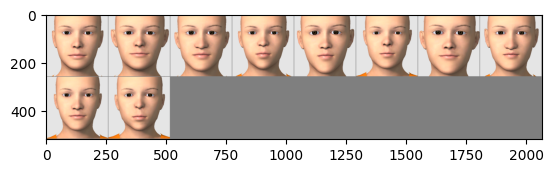

image torch.Size([10, 3, 256, 256])
conv1 torch.Size([10, 6, 252, 252])
pool1 torch.Size([10, 6, 126, 126])
conv2 torch.Size([10, 16, 122, 122])
pool2 torch.Size([10, 16, 61, 61])


In [21]:
# 이미지를 보여 주자

def imshow(img):
    img = img / 2 + 0.5  # unnormailzed
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
print('image', images.shape)
x = conv1(images)
print('conv1', x.shape)
x = pool(x)
print('pool1', x.shape)
x = conv2(x)
print('conv2', x.shape)
x = pool(x)
print('pool2', x.shape)



In [12]:
# increase the size of the dataset, various data augmentation is applied.
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Scale((224,224)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.RandomRotation(5, resample=False,expand=False, center=None),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Scale((224,224)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.RandomRotation(5, resample=False,expand=False, center=None),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}
'''

"\ndata_transforms = {\n    'train': transforms.Compose([\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Scale((224,224)),\n        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),\n        transforms.RandomRotation(5, resample=False,expand=False, center=None),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n    ]),\n    'val': transforms.Compose([\n        transforms.ToTensor(),\n        transforms.Scale((224,224)),\n        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),\n        transforms.RandomRotation(5, resample=False,expand=False, center=None),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),\n    ]),\n}\n"

In [22]:

num_classes = 33

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 33)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=33, bias=True)
)


In [23]:


# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [27]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        # print(pred)
        
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [33]:
# Training
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)    
print("Done!")

Epoch 1
-------------------------------
loss: 0.028797  [    0/  100]
Epoch 2
-------------------------------
loss: 0.028749  [    0/  100]
Epoch 3
-------------------------------
loss: 0.028886  [    0/  100]
Epoch 4
-------------------------------
loss: 0.029694  [    0/  100]
Epoch 5
-------------------------------
loss: 0.029673  [    0/  100]
Epoch 6
-------------------------------
loss: 0.030135  [    0/  100]
Epoch 7
-------------------------------
loss: 0.028912  [    0/  100]
Epoch 8
-------------------------------
loss: 0.031263  [    0/  100]
Epoch 9
-------------------------------
loss: 0.030438  [    0/  100]
Epoch 10
-------------------------------
loss: 0.027579  [    0/  100]
Done!


In [34]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            print(pred)



In [36]:
for t in range(epochs):
    test(test_loader, model, criterion)

print("Done !")

tensor([[0.4979, 0.4876, 0.4863, 0.5143, 0.5164, 0.5161, 0.4824, 0.4929, 0.5198,
         0.5064, 0.5131, 0.4891, 0.4907, 0.5046, 0.4796, 0.4937, 0.5167, 0.5277,
         0.4892, 0.5164, 0.5073, 0.4978, 0.4843, 0.4878, 0.5233, 0.4871, 0.5207,
         0.4847, 0.4798, 0.4990, 0.5237, 0.5138, 0.4828],
        [0.4838, 0.4811, 0.4834, 0.5074, 0.5126, 0.5096, 0.4724, 0.4831, 0.5113,
         0.5060, 0.5094, 0.4856, 0.4856, 0.5056, 0.4735, 0.4819, 0.5049, 0.5224,
         0.4793, 0.5027, 0.4968, 0.4851, 0.4801, 0.4844, 0.5155, 0.4807, 0.5183,
         0.4782, 0.4758, 0.4927, 0.5196, 0.5001, 0.4707],
        [0.4944, 0.4910, 0.4916, 0.5172, 0.5187, 0.5131, 0.4800, 0.4903, 0.5211,
         0.5129, 0.5165, 0.4902, 0.4963, 0.5082, 0.4827, 0.4957, 0.5166, 0.5298,
         0.4880, 0.5088, 0.5078, 0.4953, 0.4809, 0.4857, 0.5269, 0.4909, 0.5236,
         0.4845, 0.4849, 0.5004, 0.5285, 0.5031, 0.4784],
        [0.4998, 0.4926, 0.4926, 0.5167, 0.5190, 0.5179, 0.4808, 0.4953, 0.5265,
         0.5174,